In [33]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import bz2
from sklearn.datasets import load_svmlight_file
from sklearn import preprocessing
import matplotlib.pyplot as plt
from copy import copy

# Loading the dataset

In [34]:
X_train, y_train = load_svmlight_file('dataset/ijcnn1.bz2')
X_train = X_train.A

X_rescale = preprocessing.scale(X_train)

# Kernel Matrix

In [35]:
def RBF_kernel(x, y, gamma):
    return np.exp(-gamma*((x-y)**2).sum())

def get_gram_matrix(dataset, kernel, **param):
    n = dataset.shape[0]
    G = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            G[i, j] = kernel(dataset[i], dataset[j], **param)
    return G

def extract_random_rows(dataset, nrows):
    r = np.arange(dataset.shape[0])
    indices = np.random.choice(r, size=nrows, replace=False)
    return(dataset[indices])

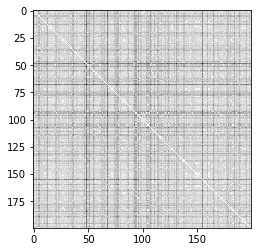

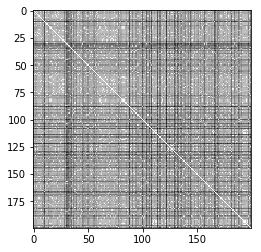

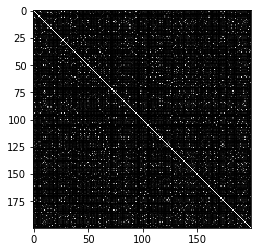

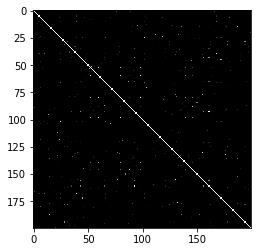

In [36]:
def plot_G_sub(data, nrows, kernel, **param):
    X = extract_random_rows(data, nrows)
    G = get_gram_matrix(X, kernel, **param)
    plt.imshow(G, cmap='gray')
    plt.show()
    
plot_G_sub(X_rescale, 200, RBF_kernel, **{'gamma':1e-3})
plot_G_sub(X_rescale, 200, RBF_kernel, **{'gamma':1e-2})
plot_G_sub(X_rescale, 200, RBF_kernel, **{'gamma':1e-1})
plot_G_sub(X_rescale, 200, RBF_kernel, **{'gamma':1})

# Clustering

In [37]:
from sklearn.cluster import KMeans

KM  = KMeans(n_clusters=10, n_jobs=-1)
KM.fit(X_rescale)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [38]:
KM.predict(X_train)[:10]

array([5, 3, 2, 1, 7, 4, 0, 8, 9, 6])

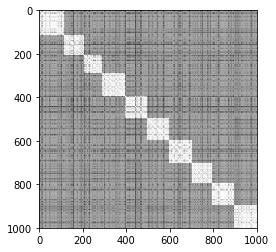

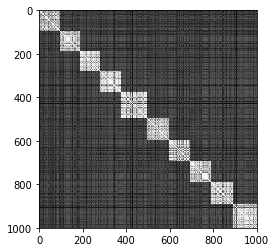

In [39]:
def plot_clust_G_sub(data, nrows, kernel, clust_alg, **param):
    X = extract_random_rows(data, nrows)
    pred = clust_alg.predict(X)
    group_indices = np.argsort(pred)
    G = get_gram_matrix(X[group_indices], kernel, **param)
    plt.imshow(G, cmap='gray')
    plt.show()

plot_clust_G_sub(X_train, 1000, RBF_kernel, KM, **{'gamma':5e-2})
plot_clust_G_sub(X_train, 1000, RBF_kernel, KM, **{'gamma':5e-1})

The clustering seems pretty relevant for the Gaussian kernel.

# Kernel Approximation Methods

In [40]:
def compute_distance(G1, G2):
    return ((G1-G2)**2).sum()

## Block Kernel Approximation

This first method consists in a clustering step, followed by the exact computation of the Gram matrix corresponding to each cluster. This method is very efficient when the distance between the clusters is relatively large (on the kernel function scale). For the RBF kernel, we propose two examples: on the first example the approximation may hold, and on the second one we see that the loss of the non-diagonal terms completely changes the structure of the Gram matrix. The interesting fact is that these two behaviours are observed with only a $\times 10$ multiplication of the scale parameter of the RBF. Due to the exponential nature of the RBF small shifts in the scale parameter can completely change the quality of the BKA.

In [41]:
from scipy.linalg import block_diag

def BKA(X, C_pred, kernel, **param):
    n_clusters = C_pred.max()+1
    blocks = []
    for c in tqdm(range(n_clusters)):
        ind = np.where(C_pred==c)
        blocks.append(get_gram_matrix(X[ind], kernel, **param))
    return block_diag(*blocks)

In [42]:
X = extract_random_rows(X_rescale, nrows=1000)
C = KM.predict(X)
ind = np.argsort(C)
X, C = X[ind], C[ind]

In [43]:
G_X = get_gram_matrix(X, RBF_kernel, **{'gamma': 5e-1})
BK_X = BKA(X, C, RBF_kernel, **{'gamma': 5e-1})

Distance bestween G and BKA(G) 0.000004


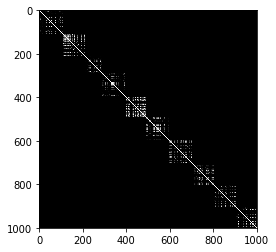

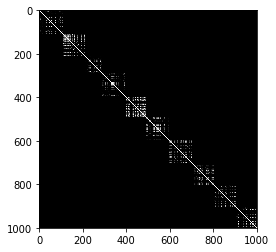

In [44]:
print('Distance bestween G and BKA(G) %f' % compute_distance(G_X, BK_X))
plt.imshow(BK_X, cmap='gray')
plt.show()
plt.imshow(G_X, cmap='gray')
plt.show()

In [45]:
G_X = get_gram_matrix(X, RBF_kernel, **{'gamma': 5e-2})
BK_X = BKA(X, C, RBF_kernel, **{'gamma': 5e-2})

Distance bestween G and BKA(G) 23490.018546


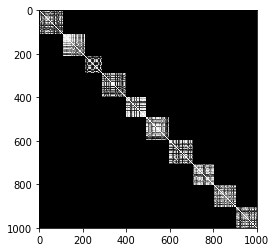

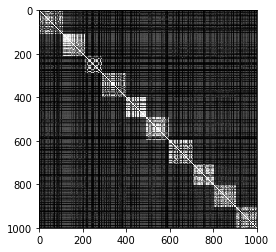

In [46]:
print('Distance bestween G and BKA(G) %f' % compute_distance(G_X, BK_X))
plt.imshow(BK_X, cmap='gray')
plt.show()
plt.imshow(G_X, cmap='gray')
plt.show()

As suggested in the paper, we propose an algorithm to find the optimal number of clusters.

In [47]:
def objective(G, C):
    obj = 0
    n_cluster = C.max() + 1
    for c in range(n_cluster):
        ind = np.where(C==c)
        obj += (G[ind]**2).sum()/ind[0].shape[0]
    return obj

def run_BKA(data, ncluster, njobs, kernel, **param):
    KM  = KMeans(n_clusters=ncluster, n_jobs=njobs)
    KM.fit(data)
    C = KM.predict(data)
    ind = np.argsort(C)
    X, C = data[ind], C[ind]
    BK = BKA(X, C, kernel, **param)
    return BK, C
    
def find_best_BKA(data, kernel, c_min, c_max, step, njobs, **param):
    obj, obj_list = 0, []
    current_max = c_min
    for c in np.arange(c_min, c_max+1, step):
        BK, C = run_BKA(data, ncluster=c, njobs=njobs, kernel=kernel, **param)
        new_obj = objective(BK, C)
        obj_list.append(new_obj)
        if new_obj > obj:
            current_max = c
            obj = new_obj
    return current_max, obj_list

In [48]:
X = extract_random_rows(X_rescale, nrows=1000)
c0, c1, s = 2, 41, 2
c_opt, obj_list = find_best_BKA(X, RBF_kernel, c_min=c0, c_max=c1, step=s, njobs=-1, **{'gamma':1e-2})

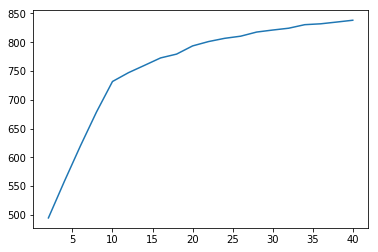

In [49]:
plt.plot(np.arange(c0, c1, s), obj_list)

In our example the objective function is strictly increasing. However, it would be strictly decreasing if we remove the penalty in the size of the clusters. So the choice of the number of clusters is actually quite arbitrary, depending on the loss function we choose.

## Nyström method

The Nyström method is a different approach to perform kernel approximation.

In [50]:
from scipy.sparse.linalg import svds

In [56]:
def get_sub_G(sub1, sub2, kernel, **param):
    """
    Return a matrix with kernel evaluation between each element 
    of sub1 and each element of sub2
    """
    n, npp = sub1.shape[0], sub2.shape[0]
    sub_G = np.zeros((n, npp))
    for i in range(n):
        for j in range(npp):
            sub_G[i, j] = kernel(sub1[i], sub2[j], **param)
    return sub_G

def Nystrom(data, m, k, kernel, return_decompo=True, **param):
    n = data.shape[0]
    sample_ind = np.random.choice(np.arange(n), m, replace=False)
    sample = data[sample_ind]
    C = get_sub_G(data, sample, kernel, **param)
    G = get_gram_matrix(sample, kernel, **param)
    U, s, Ut = svds(G, k)
    M = np.linalg.pinv(U @ np.diag(s) @ Ut)
    if return_decompo:
        return C, M
    return C @ M @ C.T

In [57]:
X = extract_random_rows(X_rescale, nrows=1000)
C = KM.predict(X)
ind = np.argsort(C)
X, C = X[ind], C[ind]

In [65]:
G_X = get_gram_matrix(X, RBF_kernel, **{'gamma': 5e-2})
C, M = Nystrom(X, 1000, 999, RBF_kernel, return_decompo=True, **{'gamma':5e-2})

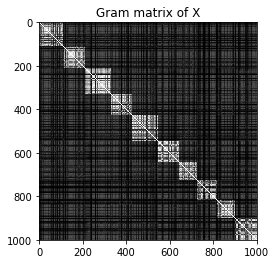

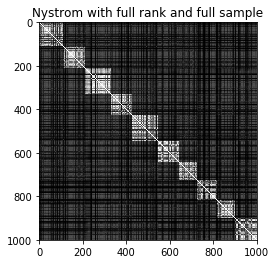

In [66]:
plt.imshow(G_X, cmap='gray')
plt.title('Gram matrix of X')
plt.show()
plt.imshow(C @ M @ C.T, cmap='gray')
plt.title('Nystrom with full rank and full sample')
plt.show()

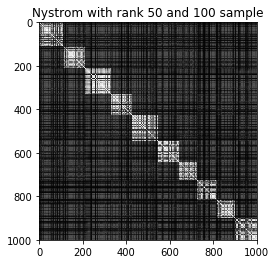

In [74]:
M = Nystrom(X, 300, 100, RBF_kernel, return_decompo=False, **{'gamma':5e-2})
plt.imshow(M, cmap='gray')
plt.title('Nystrom with rank 100 and 300 sample')
plt.show()

In [75]:
print('Distance between the Gram Matrix and Nystrom: %f' % compute_distance(G_X, M))

Distance between the Gram Matrix and Nystrom: 164.083536


Remake gridsearch and marginal effect of m and k

## Memory Efficient Kernel Approximation

In [146]:
from skimage.util import view_as_blocks

def solve_lsp(Ws, Wt, Gst):
    l_term = np.linalg.inv(Ws @ Ws.T)
    r_term = np.linalg.inv(Wt @Wt.T)
    return l_term @ Ws @ Gst @ Wt @ r_term

def MEKA(data, C, m, k, rho, kernel, **param):
    n, n_cluster = data.shape[0], int(C.max())+1
    cl_size, cl_ind = [], []
    diag_L, diag_W, all_L = [], [], []
    for i in range(n_cluster):
        ind = np.where(C==i)[0]
        cl_size.append(len(ind))
        cl_ind.append(ind)
        W, L = Nystrom(data[ind], m, k, kernel, **param)
        diag_L.append(L)
        diag_W.append(W)
    for i in range(n_cluster):
        wll, wrr, l = [], [], []
        for j in range(n_cluster):
            if i != j:
                vs = np.random.choice(np.arange(cl_size[i]), k*(1+rho), replace=False)
                vt = np.random.choice(np.arange(cl_size[j]), k*(1+rho), replace=False)
                vs_data = cl_ind[i][vs]
                vt_data = cl_ind[j][vt]
                g = get_sub_G(data[vs_data], data[vt_data], kernel, **param)
                new_wl, new_wr = diag_W[i][vs], diag_W[j][vt]
                l.append(solve_lsp(new_wl, new_wr, g))
        all_L.append(l)
    return diag_W, diag_L, all_L

def build_G_from_MEKA(W, diag_L, L):
    L_blocks = []
    for i in range(len(W)):
        l = []
        count = 0
        for j in range(len(W)):
            if i == j:
                l.append(diag_L[i])
            else:
                l.append(L[i][count])
                count += 1
        L_blocks.append(l)
    LB = np.block(L_blocks)
    W = block_diag(*W)
    print(W.shape)
    print(LB.shape)
    return W @ LB @ W.T

In [128]:
X = extract_random_rows(X_rescale, nrows=1000)
C = KM.predict(X)
ind = np.argsort(C)
X, C = X[ind], C[ind]

In [129]:
res = MEKA(X, C, 30, 10, 2, RBF_kernel, **{'gamma': 5e-2})

(1000, 300)
(300, 300)


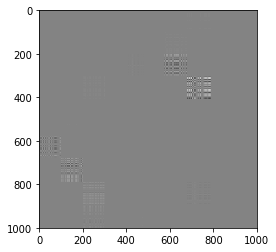

In [148]:
MEKA_X = build_G_from_MEKA(*res)
plt.imshow(MEKA_X, cmap='gray')

In [149]:
MEKA_X

array([[ 8.91213448e-01,  6.51143570e-03,  5.63248493e-01, ...,
        -7.75511452e+07, -9.83935259e+07,  1.07176455e+08],
       [ 6.51143570e-03,  6.34904000e-01,  9.60493291e-02, ...,
        -1.01253650e+08, -1.28283451e+08,  1.39428162e+08],
       [ 5.63248493e-01,  9.60493291e-02,  8.85893949e-01, ...,
        -3.92910743e+08, -4.96818155e+08,  5.34102872e+08],
       ...,
       [ 2.69264438e+05,  2.56632041e+06,  4.01708294e+06, ...,
         8.17724302e-01,  8.32469723e-01,  4.64412713e-01],
       [ 5.25775831e+05,  4.30476999e+06,  6.90054930e+06, ...,
         8.32469723e-01,  9.57994364e-01,  4.60469604e-01],
       [-3.65813145e+04, -1.94310494e+05, -3.21078666e+05, ...,
         4.64412713e-01,  4.60469604e-01,  7.20377902e-01]])